## Twitter Sentimental Analysis - Cyberbullying

### Hemant Thapa

#### Import Libraries 

In [1]:
import re
import nltk
import emoji
import string
import pickle
import importlib
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
importlib.reload(string)
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Attention
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\heman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\heman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Loading DataSet 

In [4]:
# loading csv file
tweets_df  = pd.read_csv('cyberbullying_tweets.csv')

In [5]:
# renaming columns name
tweets_df .rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'}, inplace=True)
# removing duplicate rows 
tweets_df .drop_duplicates(subset="text", inplace=True)

In [6]:
# top five rows
tweets_df [:5]

,text,sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [7]:
# bottom five columns 
tweets_df.tail()

,text,sentiment
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity
47691,Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...,ethnicity


In [8]:
#checking information of columns 
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46017 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       46017 non-null  object
 1   sentiment  46017 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


We have two categorical columns, text and sentiments. The text column represents user comments, while the sentiments column represents user emotions and behaviors.

In [9]:
#shape of rows and columns of our dataset
tweets_df.shape

(46017, 2)

we have nearly, 46017 rows and 2 columns in our dataframe.

In [10]:
# size of dataframe row and columns 
tweets_df.size

92034

if we multiply rows and columns, we have nearly 92034 data points.

In [11]:
# counting values of sentiment columns 
tweets_df.sentiment.value_counts()

sentiment
religion               7995
age                    7992
ethnicity              7952
not_cyberbullying      7937
gender                 7898
other_cyberbullying    6243
Name: count, dtype: int64

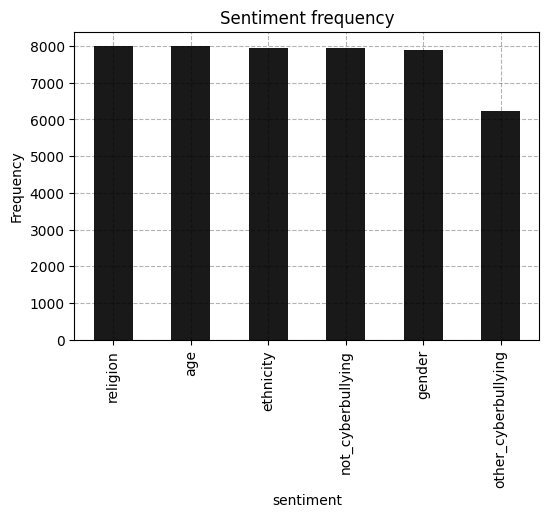

In [12]:
# counting values of sentiment columns 
plt.figure(figsize=(6,4))
tweets_df.sentiment.value_counts().plot(kind='bar', color='black', alpha=0.9)
plt.ylabel("Frequency")
plt.title('Sentiment frequency')
plt.grid(True, ls='--', alpha=0.3, color='black')
plt.show()

- Religion: 7995 occurrences
- Age: 7992 occurrences
- Ethnicity: 7952 occurrences
- Not Cyberbullying: 7937 occurrences
- Gender: 7898 occurrences
- Other Cyberbullying: 6243 occurrences

In [13]:
# statical analysis of values in sentiment columns 
tweets_df.sentiment.value_counts().describe()

count       6.000000
mean     7669.500000
std       699.776179
min      6243.000000
25%      7907.750000
50%      7944.500000
75%      7982.000000
max      7995.000000
Name: count, dtype: float64

In [14]:
# first 20 comments
for i in range(20):
    print(tweets_df['text'][i])

In other words #katandandre, your food was crapilicious! #mkr
Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc
@XochitlSuckkks a classy whore? Or more red velvet cupcakes?
@Jason_Gio meh. :P  thanks for the heads up, but not too concerned about another angry dude on twitter.
@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account.  Like Islam, it is all lies.
@Raja5aab @Quickieleaks Yes, the test of god is that good or bad or indifferent or weird or whatever, it all proves gods existence.
Itu sekolah ya bukan tempat bully! Ga jauh kaya neraka
Karma. I hope it bites Kat on the butt. She is just nasty. #mkr
@stockputout everything but mostly my priest
Rebecca Black Drops Out of School Due to Bullying:
@Jord_Is_Dead http://t.co/UsQInYW5Gn
The Bully flushes on KD http://twitvid.com/A2TNP
Ughhhh #MKR
RT @Kurdsnews: Turkish state has killed 241 children in last 11 years http://t.co/JlvkE1epws  #news  ##Googl

In [15]:
# bottom 20 comments
total_rows = len(tweets_df)
for i in range(total_rows - 20, total_rows):
    print(tweets_df['text'][i])

Going to ride wid my chopper friend dem!! Fuck u broke niggers an dumb bitchs skrr skrr u c me onda blocka!!
DRINK CUM AND EAT POOP YOU BITCH ASS FAGGOT FUCKING NIGGER WHITE POWER DUMB NIGGERS WHITE POWER RULES OVER YOU ALL BOW THE FUCK DOWN
Shut the fuck up, Red, you dumb nigger.
RT @tayyoung_ FUCK OBAMA, dumb ass nigger &lt;&lt;&lt;&lt;She mad llf. #4MoreYears
@Blind_Brian Haha Holy fuck. You're a dumb nigger. You would see me at the arcade hoops game.
Fuck these dumb niggers in here
The pure hatred some of you niggers have for black women is disgusting. Like truly seek help.
Did you ever had a friend that say's doo you want a cheese burger whit cheese.somtimes he's a dumb fuck butt stil my nigger
The black lady is freaking out cuz she's prego by a guy who wears a cupcake belt n think his gay what the fuck dumb nigger lady
Fuck a nigger with a nigger that fucks with dumb broke niggas #broke#niggers#stay#broke#don't#fuck#with#emm
Disgusting "@Shelly_Smyth: I hope nigger Obama loses th

In [16]:
# total missing values
tweets_df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [17]:
# encoding sentiment in digits
tweets_df["encode"] = tweets_df["sentiment"].replace({"religion": 1, 
                                                    "age": 2, 
                                                    "ethnicity": 3,
                                                    "gender": 4, 
                                                    "other_cyberbullying": 5,
                                                    "not_cyberbullying": 6})

In [18]:
# checking encoded columns 
tweets_df[:5]

,text,sentiment,encode
0,"In other words #katandandre, your food was cra...",not_cyberbullying,6
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,6
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,6
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,6
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,6


In [19]:
# importing unicode_range.py file and list 
from unicode_range import unicode_range

In [25]:
# contractions dictionary
contractions_dict = {
    "can't": "cannot",
    "can\'t": "cannot",
    "n't": " not",
    "n\'t": " not",
    "'re": " are",
    "’re": " are",
    "'s": " is",
    "’s": " is",
    "'d": " would",
    "’d": " would",
    "'ll": " will",
    "’ll": " will",
    "'t": " not",
    "’t": " not",
    "'ve": " have",
    "’ve": " have",
    "'m": " am",
    "’m": " am",
    "I'm": "I am",
    "i'm": "i am",
    "you're": "you are",
    "he's": "he is",
    "they're": "they are",
    "we're": "we are",
    "it's": "it is",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "won't": "will not",
    "wouldn't": "would not",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "cannot": "can not",
    "could've": "could have",
    "might've": "might have",
    "must've": "must have",
    "should've": "should have",
    "would've": "would have",
}

In [20]:
def preprocess_text(text):
    # function to remove emojis
    def remove_emoji(text, unicode_ranges):
        emoji_pattern = re.compile(f"[{''.join(unicode_ranges)}]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

    # function to expand contractions
    def expand_contractions(text, contractions_dict):
        contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

        def replace(match):
            return contractions_dict[match.group(0)]

        return contractions_re.sub(replace, text)

    # F=function to remove multiple consecutive spaces
    def remove_mult_spaces(text):
        return re.sub(r'\s+', ' ', text).strip()

    # function to remove symbols, hashtags, and punctuation
    def removing_symbols(text):
        text_without_hashtags = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text))
        text_without_underscores = " ".join(word.strip() for word in re.split('#|_', text_without_hashtags))
        cleaned_text = re.sub(r'[!?]', '', text_without_underscores)
        return cleaned_text

    # function to filter out words containing '$' or '&'
    def filter_char(text):
        filtered_words = [word for word in text.split() if '$' not in word and '&' not in word]
        return ' '.join(filtered_words)

    # remove emojis
    text = remove_emoji(text, unicode_range)
    # expand contractions
    text = expand_contractions(text, contractions_dict)
    # normalise whitespace and lowercase the text
    text = text.replace('\r', '').replace('\n', ' ').lower()
    # remove URLs, non-ASCII characters, and numbers
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    non_ascii_pattern = re.compile(r'[^\x00-\x7f]')
    number_pattern = re.compile(r'[0-9]+')
    text = url_pattern.sub('', text)
    text = non_ascii_pattern.sub('', text)
    text = number_pattern.sub('', text)
    # remove punctuation using translate
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove symbols, hashtags, and punctuation
    text = removing_symbols(text)
    # filter out words containing '$' or '&'
    text = filter_char(text)
    # remove multiple consecutive spaces
    text = remove_mult_spaces(text)

    return text

In [22]:
tweets_df['cleaned_text'] = tweets_df['text'].apply(preprocess_text)

In [24]:
# first 20 comments
for i in range(20):
    print(tweets_df['cleaned_text'][i])

in other words katandandre your food was crapilicious mkr
why is aussietv so white mkr theblock imacelebrityau today sunrise studio neighbours wonderlandten etc
xochitlsuckkks a classy whore or more red velvet cupcakes
jasongio meh p thanks for the heads up but not too concerned about another angry dude on twitter
rudhoeenglish this is an isis account pretending to be a kurdish account like islam it is all lies
rajaaab quickieleaks yes the test of god is that good or bad or indifferent or weird or whatever it all proves gods existence
itu sekolah ya bukan tempat bully ga jauh kaya neraka
karma i hope it bites kat on the butt she is just nasty mkr
stockputout everything but mostly my priest
rebecca black drops out of school due to bullying
jordisdead
the bully flushes on kd
ughhhh mkr
rt kurdsnews turkish state has killed children in last years news googleeviricitopluluukrteyidee
love that the best response to the hotcakes they managed to film was a noncommittal meh from some adolescent

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [27]:
# tokenize text data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(tweets_df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(tweets_df['cleaned_text'])
padded_sequences = pad_sequences(sequences, padding='post')

In [28]:
train_texts, test_texts, train_labels, test_labels = train_test_split( tweets_df['cleaned_text'], 
                                                                       tweets_df['encode'], 
                                                                       test_size=0.2, 
                                                                       random_state=0
                                                                    )

In [29]:
(train_texts.shape, train_labels.shape), (test_texts.shape, test_labels.shape)

(((36813,), (36813,)), ((9204,), (9204,)))

In [30]:
tokenizer = Tokenizer(num_words=10000) 
tokenizer.fit_on_texts(train_texts)

# texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# pad the sequences to ensure uniform length
train_padded = pad_sequences(train_sequences, maxlen=100)  
test_padded = pad_sequences(test_sequences, maxlen=100)


In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=100),  
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')  
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
train_labels = train_labels - 1
test_labels = test_labels - 1

In [33]:
history = model.fit(train_padded, train_labels, epochs=50, validation_data=(test_padded, test_labels))

Epoch 1/50
1151/1151 [==============================] - 5s 4ms/step - loss: 1.2381 - accuracy: 0.5447 - val_loss: 0.7059 - val_accuracy: 0.7510
Epoch 2/50
1151/1151 [==============================] - 5s 4ms/step - loss: 0.5595 - accuracy: 0.7778 - val_loss: 0.4919 - val_accuracy: 0.7874
Epoch 3/50
1151/1151 [==============================] - 4s 4ms/step - loss: 0.4480 - accuracy: 0.8003 - val_loss: 0.4480 - val_accuracy: 0.7990
Epoch 4/50
1151/1151 [==============================] - 4s 4ms/step - loss: 0.4061 - accuracy: 0.8181 - val_loss: 0.4370 - val_accuracy: 0.8130
Epoch 5/50
1151/1151 [==============================] - 4s 4ms/step - loss: 0.3754 - accuracy: 0.8390 - val_loss: 0.4160 - val_accuracy: 0.8201
Epoch 6/50
1151/1151 [==============================] - 4s 4ms/step - loss: 0.3502 - accuracy: 0.8527 - val_loss: 0.4169 - val_accuracy: 0.8200
Epoch 7/50
1151/1151 [==============================] - 5s 4ms/step - loss: 0.3283 - accuracy: 0.8655 - val_loss: 0.4044 - val_accuracy:

In [34]:
test_loss, test_acc = model.evaluate(test_padded, test_labels)
print('Test Accuracy:', test_acc)

288/288 [==============================] - 1s 2ms/step - loss: 1.0489 - accuracy: 0.8142
Test Accuracy: 0.8142111897468567


In [35]:
y_pred = model.predict(test_padded)

288/288 [==============================] - 1s 2ms/step


In [36]:
y_pred[:1]

array([[1.0000000e+00, 8.9294946e-11, 4.2937519e-15, 3.5934170e-20,
        6.1576695e-17, 1.6145799e-18]], dtype=float32)

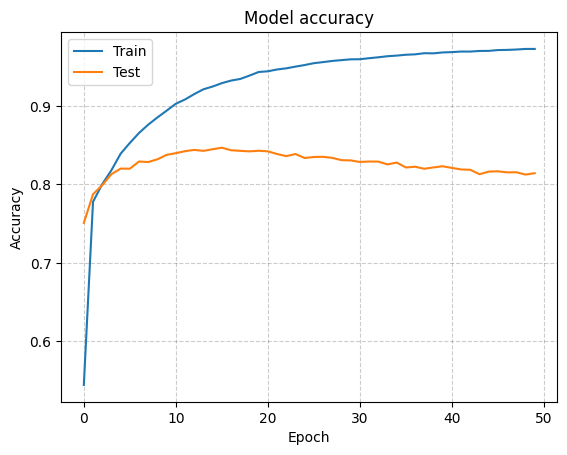

In [37]:
# training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid(True, ls='--', alpha=0.2, color='black')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

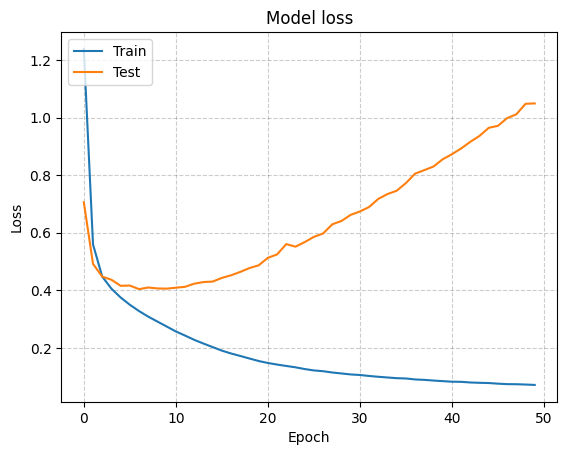

In [38]:
# training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True, ls='--', alpha=0.2, color='black')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

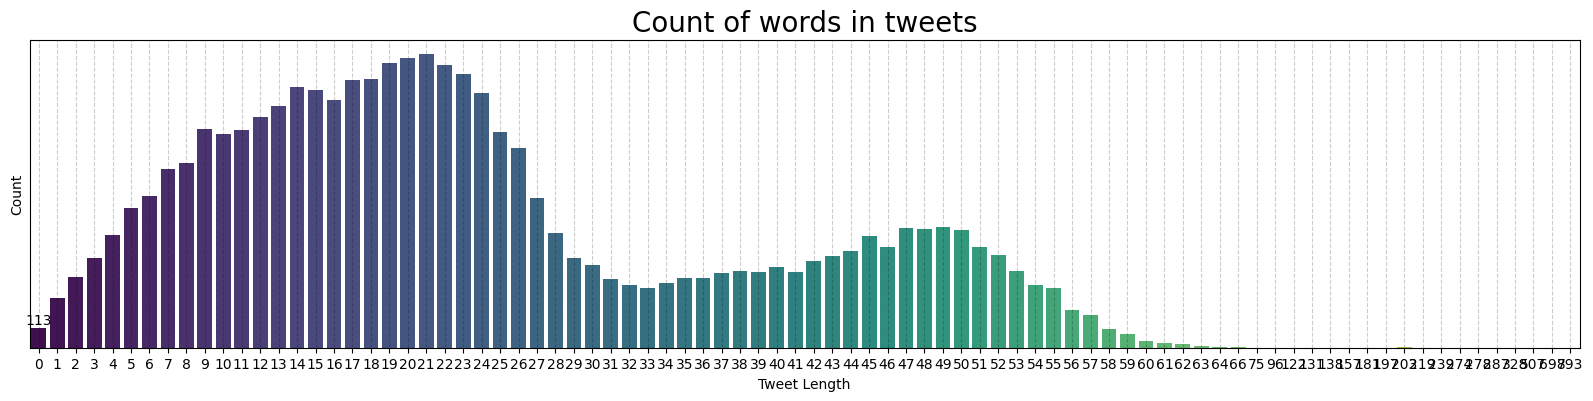

In [39]:
# length of each preprocessed tweet
text_len = [len(text.split()) for text in tweets_df['cleaned_text']]  
tweets_df['text_len'] = text_len

plt.figure(figsize=(20,4))
ax = sns.countplot(x='text_len', data=tweets_df, palette='viridis')
plt.title('Count of words in tweets', fontsize=20)
plt.grid(True, ls='--', alpha=0.2, color='black')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Count')
plt.xlabel('Tweet Length')
plt.show()

In [40]:
def plot_wordcloud(cyberbullying_type, dataframe):
    string = " ".join(dataframe[dataframe['sentiment'] == cyberbullying_type]['cleaned_text'].values)
    wordcloud = WordCloud(background_color='white', max_words=2000, max_font_size=256, random_state=42, min_font_size=10,).generate(string)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(cyberbullying_type)
    plt.show()

In [41]:
not_cyberbullying_type = tweets_df[tweets_df['sentiment'] == 'not_cyberbullying']
gender_type = tweets_df[tweets_df['sentiment'] == 'gender']
religion_type = tweets_df[tweets_df['sentiment'] == 'religion']
other_cyberbullying_type = tweets_df[tweets_df['sentiment'] == 'other_cyberbullying']
age_type = tweets_df[tweets_df['sentiment'] == 'age']
ethnicity_type = tweets_df[tweets_df['sentiment'] == 'ethnicity']

In [42]:
def analyse_sentiment_category(sentiment_category, tweets_df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    # wordCloud for the sentiment 
    generate_wordcloud(sentiment_category, tweets_df, ax1)
    # top 20 words in the sentiment category
    sentiment_data = tweets_df[tweets_df['sentiment'] == sentiment_category]
    top20_words = Counter([word for text in sentiment_data['cleaned_text'] for word in text.split()]).most_common(20)
    top20_words_df = pd.DataFrame(top20_words, columns=['Top Words', 'Count'])
    #top 20 words 
    sns.barplot(data=top20_words_df, x='Count', y='Top Words', palette='viridis', ax=ax2)
    ax2.set_title(f"Top 20 Words in '{sentiment_category}' Cyberbullying")
    ax2.set_xlabel('Count')
    ax2.set_ylabel('Top Words')
    plt.grid(True, ls='--', alpha=0.3, color='gray')
    plt.tight_layout()
    plt.show()
    print("\n")

# function to generate WordCloud
def generate_wordcloud(sentiment_category, tweets_df, ax):
    string = ""
    for i in tweets_df[tweets_df.sentiment == sentiment_category].cleaned_text.values:
        string = string + " " + i.strip()
    wordcloud = WordCloud(background_color ='white', max_words=2000, max_font_size=256,
               random_state=42, width=800, height=400, min_font_size=10).generate(string)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(sentiment_category)

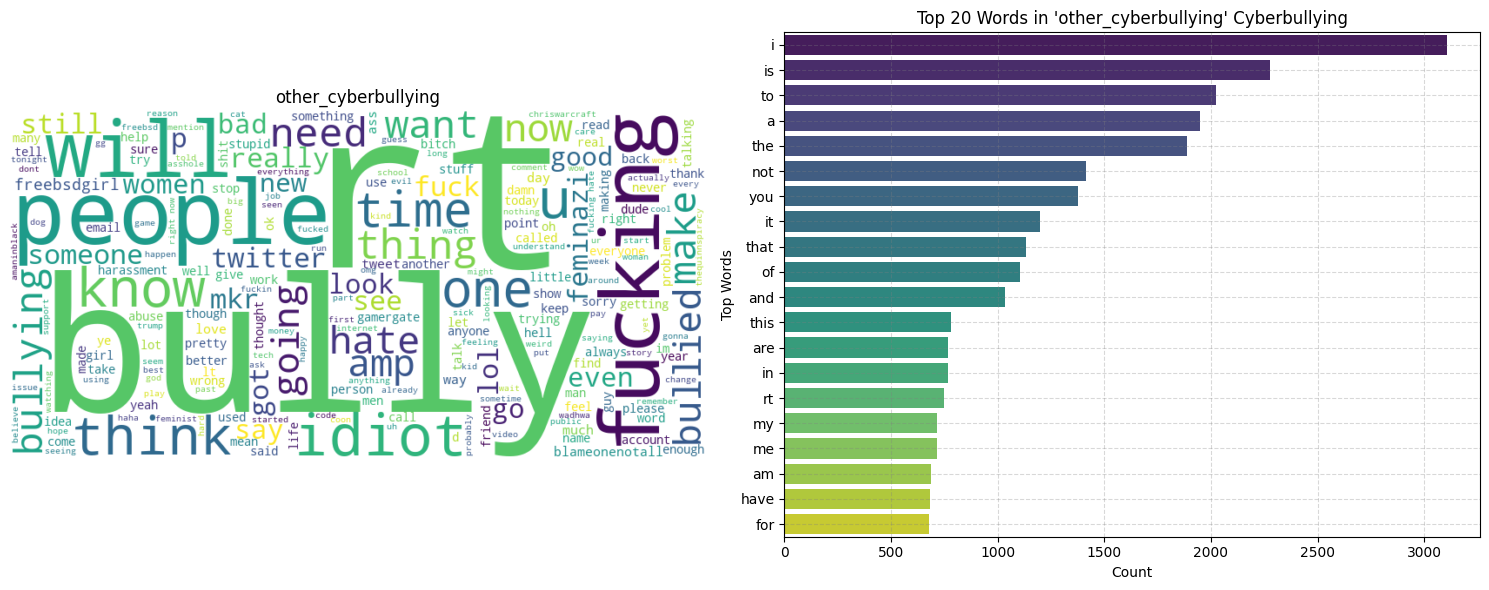

In [43]:
analyse_sentiment_category('other_cyberbullying', tweets_df)

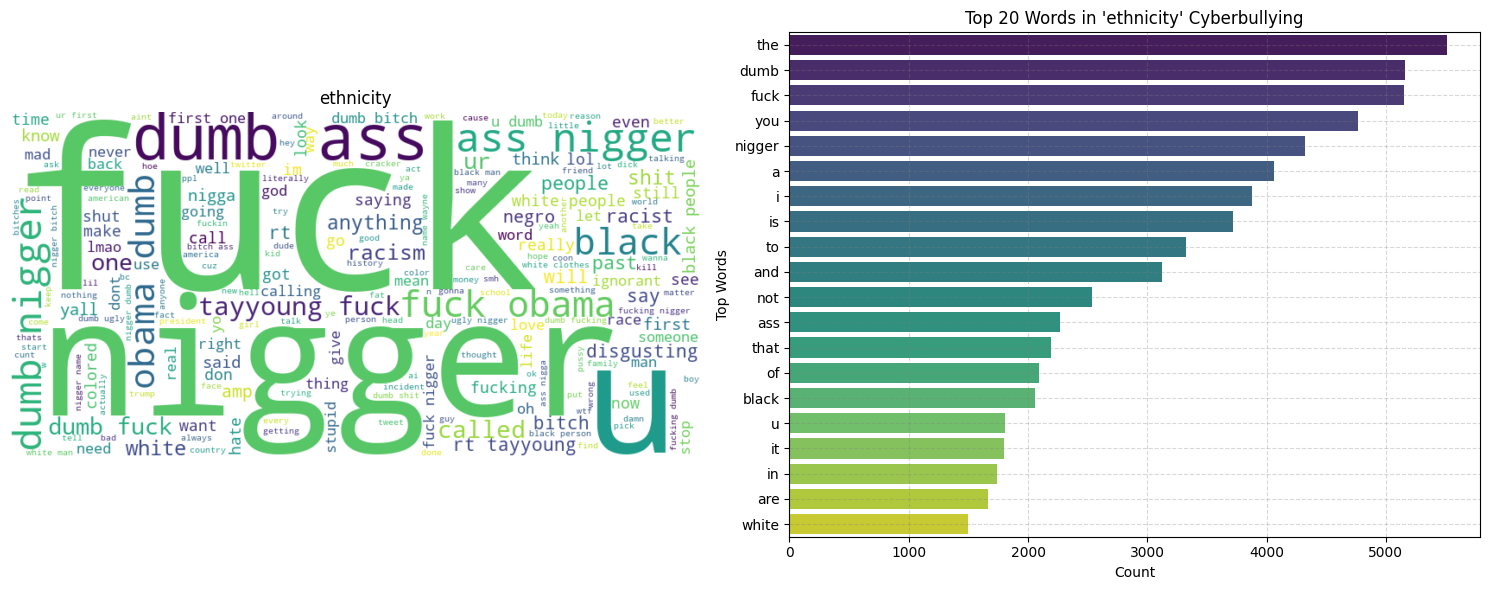

In [44]:
analyse_sentiment_category('ethnicity', tweets_df)

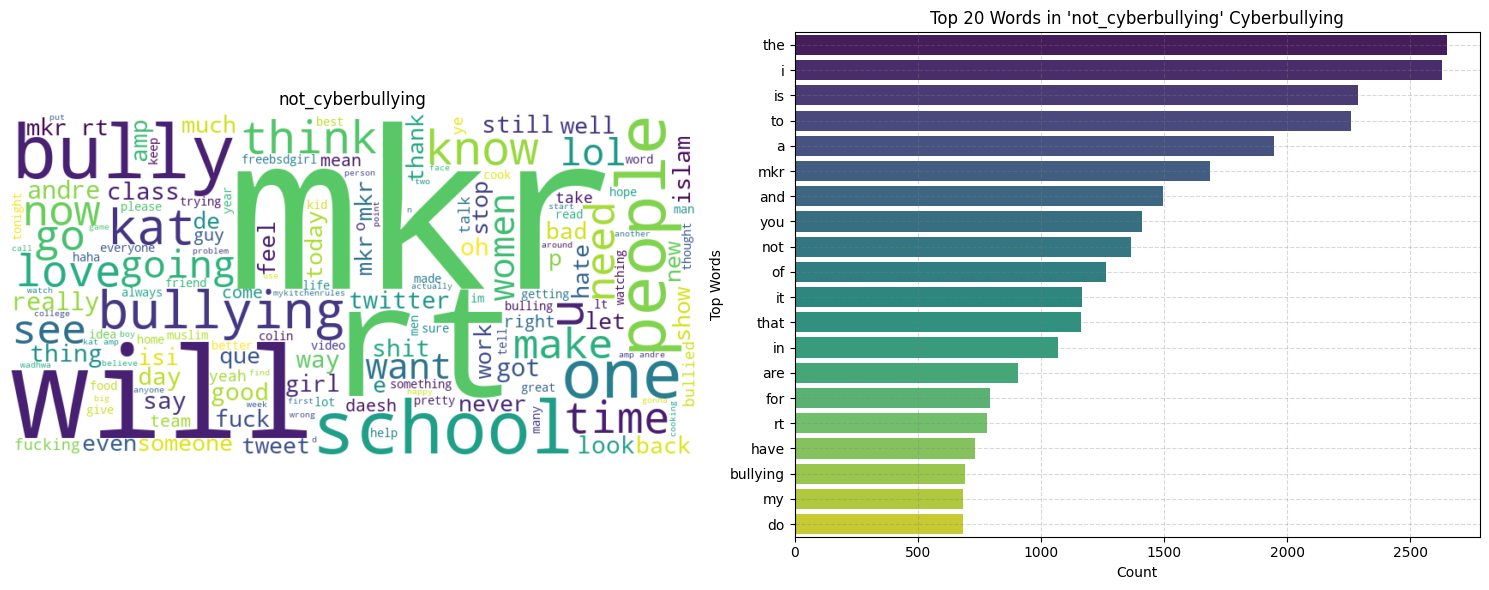

In [45]:
analyse_sentiment_category('not_cyberbullying', tweets_df)

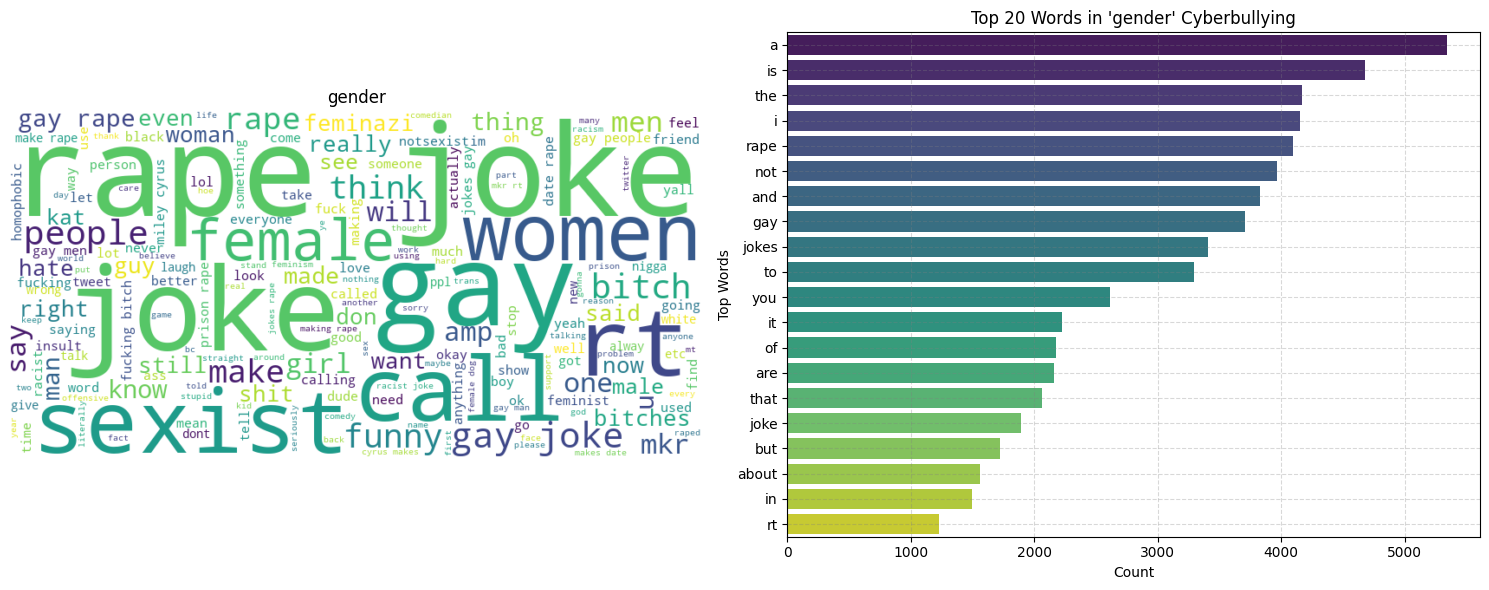

In [46]:
analyse_sentiment_category('gender', tweets_df)

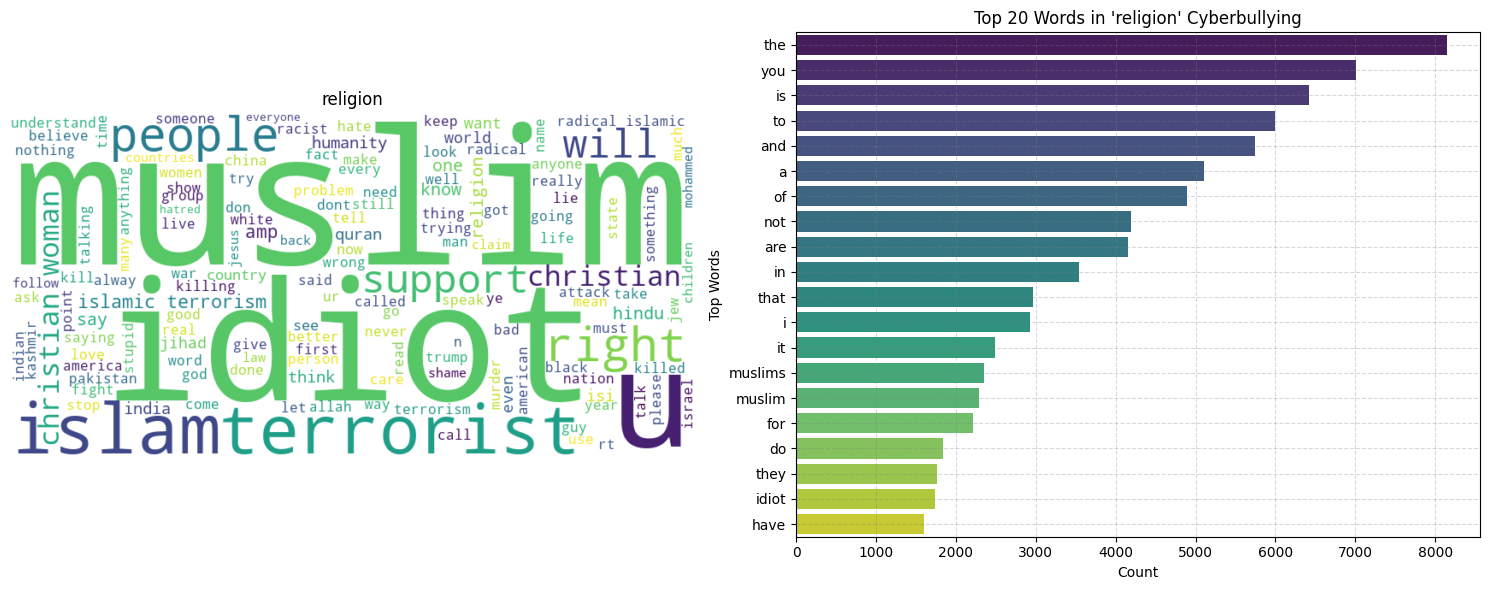

In [47]:
analyse_sentiment_category('religion', tweets_df)

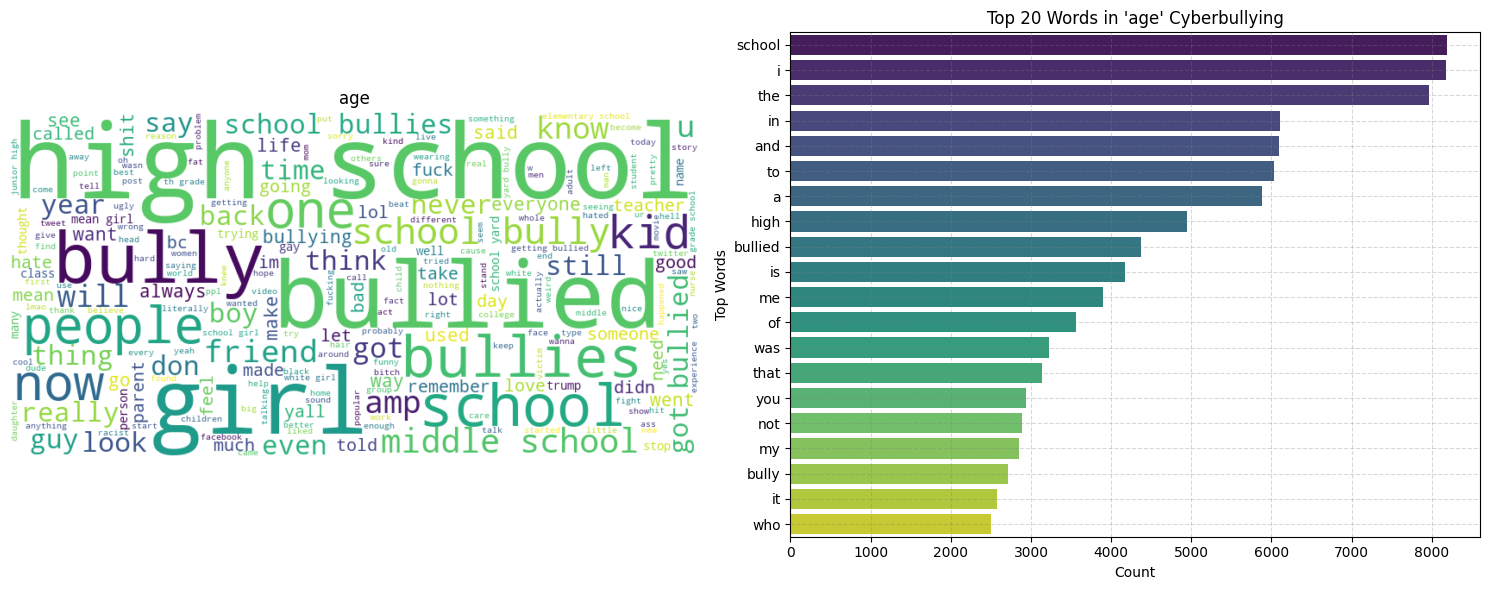

In [48]:
analyse_sentiment_category('age', tweets_df)

In [49]:
#creating object tokenizer or model
tokenizer = Tokenizer()

In [60]:
training_size = 36813

In [62]:
sentences = len(tweets_df)
sentences

46017

In [64]:
# print(f"Training size of data : {training_size}")
# print(f"Testing size of data : {len(sentences) - training_size}")

In [53]:
#corpus varibles to convert and store data into lower case plus create sentences 
corpus = tweets_df['cleaned_text']

In [54]:
tokenizer.fit_on_texts(corpus)